

<hr style="margin-bottom: 40px;">

# Principal - Backtesting

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## (A) (B) Simplified

In [344]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

df = pd.read_excel("Principal.xlsx", parse_dates=True, index_col="date")
df.apply(pd.to_numeric, errors='ignore')
df = df.rename(columns=lambda x: x.strip())
df = df.dropna(axis="index",how="all") #drop NaN values. The earliest data starts from 2001-11-20.
df = df.drop(["PRSSCOA HK Equity"],axis=1)

In [345]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return

In [346]:
describe = df.describe()
describe = pd.DataFrame(describe)
describe = describe.T
describe

,count,mean,std,min,25%,50%,75%,max
PRIAGSD HK Equity,1563.0,20.006846,2.112108,15.6100,18.160000,19.81000,21.940000,24.7500
PRIGLGC HK Equity,4801.0,16.644212,5.180473,7.4400,11.740000,17.18000,20.650000,26.5500
PRIHDSC HK Equity,4763.0,10.756074,0.300939,10.0390,10.383300,10.89080,10.937000,11.3056
PRILTAC HK Equity,4766.0,14.554230,3.491566,8.3228,11.042025,14.89255,17.333125,20.9627
PRILTGC HK Equity,4766.0,11.467751,1.366887,8.1355,10.296325,11.81295,12.709800,13.7850
PRICAPC HK Equity,4767.0,10.959695,0.402181,10.0980,10.450350,11.19940,11.229500,11.5160
PRASBON HK Equity,1798.0,9.981389,0.312778,9.4659,9.756450,9.90505,10.125125,10.9521
PRISTYC HK Equity,4766.0,14.457342,2.802819,9.4267,11.751625,14.97250,16.683100,19.5264


In [347]:
# get a list of all the column names 
indexNamesArr = describe.index.values
# convert ndarray to list
listOfRowIndexLabels = list(indexNamesArr)

coord = [(0.038802, 1.598254),( 0.023617, 0.745137),( 0.025753, 0.802417),( 0.045350, 2.066649),( 0.106415, 0.574546),( 0.053244, 0.432762),( 0.039204, 1.853161),( 0.059571, 0.444722),( 0.024976, 2.706996),( 0.012862, 0.312357),( 0.039587, 2.285998),( 0.001826, 0.044556),( 0.027979, 1.050875),( 0.032775, 1.438767),( 0.040590, 2.009521),( 0.042759, 2.400255)]
labels = listOfRowIndexLabels

def plot_with_labels(coord, labels):
    assert len(coord) == len(labels), 'coord len is not equal to labels len'
    plt.figure(figsize=(10,30))
    plt.xlabel('Mean historic return')
    plt.ylabel('volatility')
    plt.title("Performance of Principal Funds")
    plt
    for i, label in enumerate(labels): #get (0, label)
        x, y = coord[i] #2 dim
        plt.scatter(x, y,)
                #
        plt.annotate(label,
                xy=(x, y), #show point 
                xytext=(5, 2), #show annotate
                textcoords='offset points',
                ha='right',
                va='bottom')
    plt.show()
    
plot_with_labels(coord, labels)

AssertionError: coord len is not equal to labels len

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## (C) - Backtesting and Optimization

### Split training set and test set

1. Split data in train and test set given a Date (i.e. test set is what happens after 31 July 2020 not included).

2. Further split train set into train set and validation set (i.e. what happens before 31 July 2020 included) in 6 consecutive time folds.

Then, in order not lo lose the time information, perform the following steps:
 
one = Train on fold 10,11,12,13 (2010-08-01 to 2014-07-31) –>  Test on fold 14 (2014-08-01 to 2015-07-31)

two = Train on fold 11,12,13,14 –>  Test on fold 15 

three = Train on fold 12,13,14,15 –>  Test on fold 16

four = Train on fold 13,14,15,16 –>  Test on fold 17

five = Train on fold 14,15,16,17 –>  Test on fold 18

six = Train on fold 15,16,17,18 –>  Test on fold 19 (2019-08-01 to 2020-07-31)

Compute the average of the accuracies of the 6 test folds.

In [367]:
S = CovarianceShrinkage(df).ledoit_wolf()
mu = mean_historical_return(df)
from datetime import date
#train sets
one = df[(df.index > pd.Timestamp(date(2001,11,20))) & (df.index < pd.Timestamp(date(2004,7,31)))]
two = df[(df.index > pd.Timestamp(date(2002,8,1))) & (df.index < pd.Timestamp(date(2005,7,31)))]
three = df[(df.index > pd.Timestamp(date(2003,8,1))) & (df.index < pd.Timestamp(date(2006,7,31)))]
four = df[(df.index > pd.Timestamp(date(2004,8,1))) & (df.index < pd.Timestamp(date(2007,7,31)))]
five = df[(df.index > pd.Timestamp(date(2005,8,1))) & (df.index < pd.Timestamp(date(2008,7,31)))]
six = df[(df.index > pd.Timestamp(date(2006,8,1))) & (df.index < pd.Timestamp(date(2009,7,31)))]
seven = df[(df.index > pd.Timestamp(date(2007,8,1))) & (df.index < pd.Timestamp(date(2010,7,31)))]
eight = df[(df.index > pd.Timestamp(date(2008,8,1))) & (df.index < pd.Timestamp(date(2011,7,31)))]
nine = df[(df.index > pd.Timestamp(date(2009,8,1))) & (df.index < pd.Timestamp(date(2012,7,31)))]
ten = df[(df.index > pd.Timestamp(date(2010,8,1))) & (df.index < pd.Timestamp(date(2013,7,31)))]
eleven = df[(df.index > pd.Timestamp(date(2011,8,1))) & (df.index < pd.Timestamp(date(2014,7,31)))]
twelve = df[(df.index > pd.Timestamp(date(2012,8,1))) & (df.index < pd.Timestamp(date(2015,7,31)))]
thirteen = df[(df.index > pd.Timestamp(date(2013,8,1))) & (df.index < pd.Timestamp(date(2016,7,31)))]
fourteen = df[(df.index > pd.Timestamp(date(2014,8,1))) & (df.index < pd.Timestamp(date(2017,7,31)))]
fifteen = df[(df.index > pd.Timestamp(date(2015,8,1))) & (df.index < pd.Timestamp(date(2018,7,31)))]

#validation sets
tone = df[(df.index > pd.Timestamp(date(2004,8,1))) & (df.index < pd.Timestamp(date(2006,7,31)))]
ttwo = df[(df.index > pd.Timestamp(date(2005,8,1))) & (df.index < pd.Timestamp(date(2007,7,31)))]
tthree = df[(df.index > pd.Timestamp(date(2006,8,1))) & (df.index < pd.Timestamp(date(2008,7,31)))]
tfour = df[(df.index > pd.Timestamp(date(2007,8,1))) & (df.index < pd.Timestamp(date(2009,7,31)))]
tfive = df[(df.index > pd.Timestamp(date(2008,8,1))) & (df.index < pd.Timestamp(date(2010,7,31)))]
tsix = df[(df.index > pd.Timestamp(date(2009,8,1))) & (df.index < pd.Timestamp(date(2011,7,31)))]
tseven = df[(df.index > pd.Timestamp(date(2010,8,1))) & (df.index < pd.Timestamp(date(2012,7,31)))]
teight = df[(df.index > pd.Timestamp(date(2011,8,1))) & (df.index < pd.Timestamp(date(2013,7,31)))]
tnine = df[(df.index > pd.Timestamp(date(2012,8,1))) & (df.index < pd.Timestamp(date(2014,7,31)))]
tten = df[(df.index > pd.Timestamp(date(2013,8,1))) & (df.index < pd.Timestamp(date(2015,7,31)))]
televen = df[(df.index > pd.Timestamp(date(2014,8,1))) & (df.index < pd.Timestamp(date(2016,7,31)))]
ttwelve = df[(df.index > pd.Timestamp(date(2015,8,1))) & (df.index < pd.Timestamp(date(2017,7,31)))]
tthirteen = df[(df.index > pd.Timestamp(date(2016,8,1))) & (df.index < pd.Timestamp(date(2018,7,31)))]
tfourteen = df[(df.index > pd.Timestamp(date(2017,8,1))) & (df.index < pd.Timestamp(date(2019,7,31)))]
tfifteen = df[(df.index > pd.Timestamp(date(2018,8,1))) & (df.index < pd.Timestamp(date(2020,7,31)))]



In [368]:
#Calculating risk (covariance matrix) for different train periods.
S1 = CovarianceShrinkage(one).ledoit_wolf()
S2 = CovarianceShrinkage(two).ledoit_wolf()
S3 = CovarianceShrinkage(three).ledoit_wolf()
S4 = CovarianceShrinkage(four).ledoit_wolf()
S5 = CovarianceShrinkage(five).ledoit_wolf()
S6 = CovarianceShrinkage(six).ledoit_wolf()
S7 = CovarianceShrinkage(seven).ledoit_wolf()
S8 = CovarianceShrinkage(eight).ledoit_wolf()
S9 = CovarianceShrinkage(nine).ledoit_wolf()
S10 = CovarianceShrinkage(ten).ledoit_wolf()
S11 = CovarianceShrinkage(eleven).ledoit_wolf()
S12 = CovarianceShrinkage(twelve).ledoit_wolf()
S13 = CovarianceShrinkage(thirteen).ledoit_wolf()
S14 = CovarianceShrinkage(fourteen).ledoit_wolf()
S15 = CovarianceShrinkage(fifteen).ledoit_wolf()

'''plot them for the presentation.
plotting.plot_covariance(S1, plot_correlation=True)
plotting.plot_covariance(S2, plot_correlation=True)
plotting.plot_covariance(S3, plot_correlation=True)
plotting.plot_covariance(S4, plot_correlation=True)
plotting.plot_covariance(S5, plot_correlation=True)
plotting.plot_covariance(S6, plot_correlation=True)
'''

#Calculating the expected returns for different train periods.
mu1 = mean_historical_return(one)
mu2 = mean_historical_return(two)
mu3 = mean_historical_return(three)
mu4 = mean_historical_return(four)
mu5 = mean_historical_return(five)
mu6 = mean_historical_return(six)
mu7 = mean_historical_return(seven)
mu8 = mean_historical_return(eight)
mu9 = mean_historical_return(nine)
mu10 = mean_historical_return(ten)
mu11 = mean_historical_return(eleven)
mu12 = mean_historical_return(twelve)
mu13 = mean_historical_return(thirteen)
mu14 = mean_historical_return(fourteen)
mu15 = mean_historical_return(fifteen)

'''plot and show them for the presentation.
mu1
mu1.plot.barh(figsize=(10,6))
(same for others)
'''

#Calculating the expected returns for different validation periods.
tmu1 = mean_historical_return(tone)
tmu2 = mean_historical_return(ttwo)
tmu3 = mean_historical_return(tthree)
tmu4 = mean_historical_return(tfour)
tmu5 = mean_historical_return(tfive)
tmu6 = mean_historical_return(tsix)
tmu7 = mean_historical_return(tseven)
tmu8 = mean_historical_return(teight)
tmu9 = mean_historical_return(tnine)
tmu10 = mean_historical_return(tten)
tmu11 = mean_historical_return(televen)
tmu12 = mean_historical_return(ttwelve)
tmu13 = mean_historical_return(tthirteen)
tmu14 = mean_historical_return(tfourteen)
tmu15 = mean_historical_return(tfifteen)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Function 1a - Portfolio Optimization for maximal Sharpe ratio
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)



## 1st five-year Backtesting (for Function 1a)
### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.99999)])
Performance of function 1a portfolio in train period:


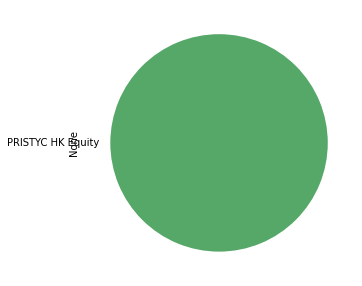

In [369]:
ef = EfficientFrontier(mu1, S1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 2.3%
Annual volatility: 8.0%
Sharpe Ratio: 0.04


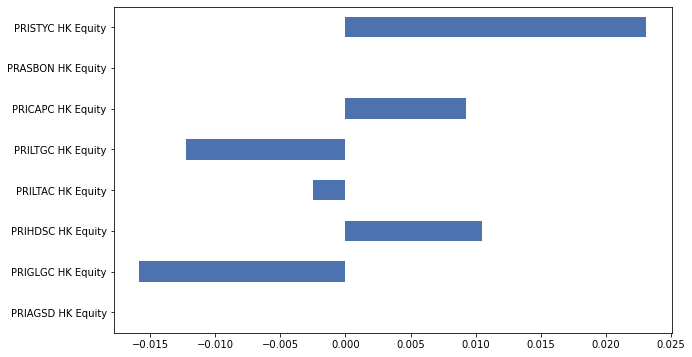

In [370]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
11.295773031832784
Portfolio return compared to train set (+- %):
8.983339742880494
Percentage change compared to train set (+- %):
388.4799525157605
Compare to benchmark (+- %):
6.195773031832784


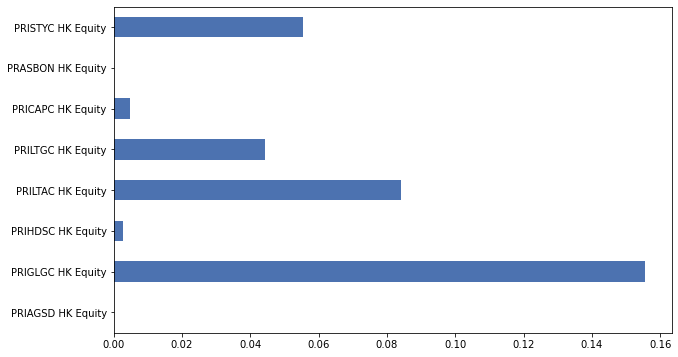

In [371]:
#calculate the asset returns in our portfolio.
ret_data = tone.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff1 = (sum(port_ret) - ret)*100
print(diff1)
print("Percentage change compared to train set (+- %):")
perch1 = diff1/ret
print(perch1)
compare1=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare1)

tmu1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 2nd five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.46005), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.07405), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.4659)])
Performance of function 1a portfolio in train period:


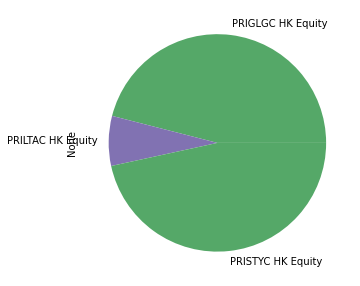

In [372]:
ef = EfficientFrontier(mu2, S2)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 6.7%
Annual volatility: 5.9%
Sharpe Ratio: 0.78


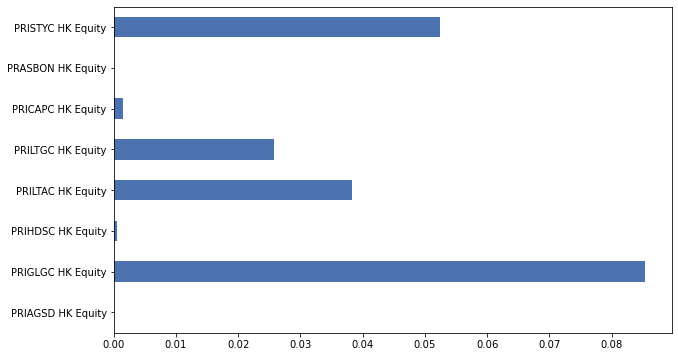

In [373]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu2.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
22.33714931755408
Portfolio return compared to train set (+- %):
15.685583824284516
Percentage change compared to train set (+- %):
235.81792647394198
Compare to benchmark (+- %):
17.237149317554078


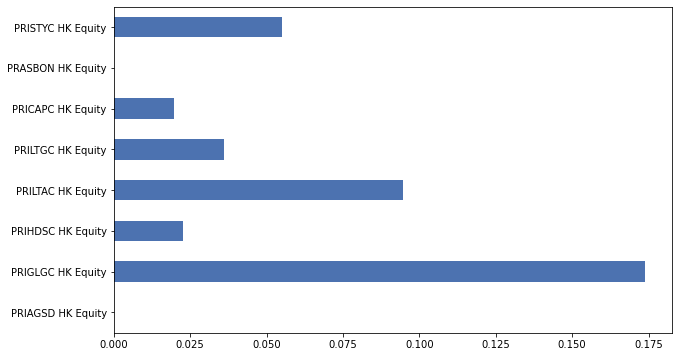

In [374]:
#calculate the asset returns in our portfolio.
ret_data = ttwo.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff2 = (sum(port_ret) - ret)*100
print(diff2)
print("Percentage change compared to train set (+- %):")
perch2 = diff2/ret
print(perch2)
compare2=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare2)

tmu2.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 3rd five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.56002), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.06583), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.37415)])
Performance of function 1a portfolio in train period:


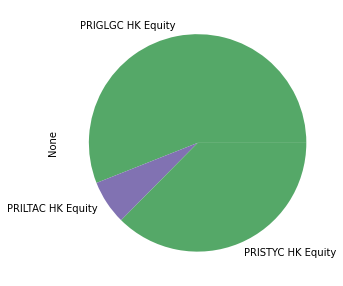

In [375]:
ef = EfficientFrontier(mu3, S3)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 12.7%
Annual volatility: 5.9%
Sharpe Ratio: 1.81


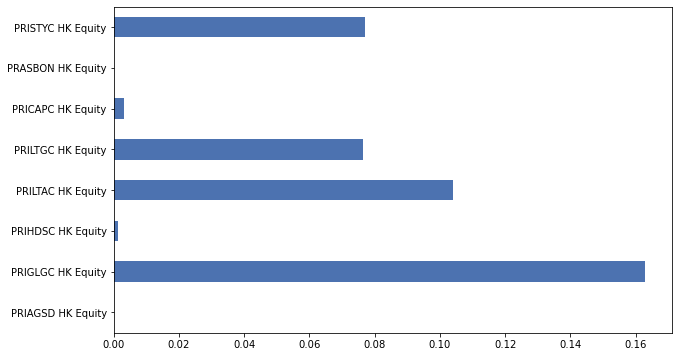

In [376]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu3.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
24.60747925463673
Portfolio return compared to train set (+- %):
11.92291230391108
Percentage change compared to train set (+- %):
93.99542254951795
Compare to benchmark (+- %):
19.507479254636728


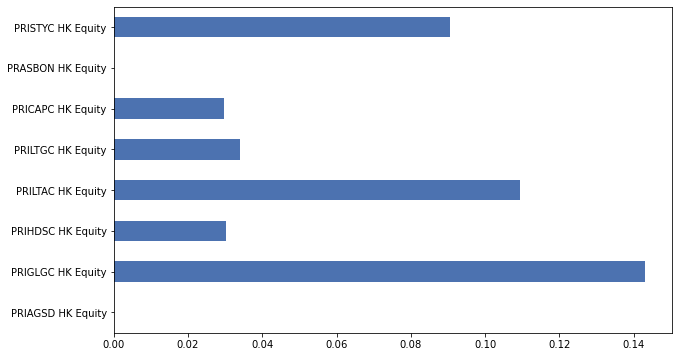

In [377]:
#calculate the asset returns in our portfolio.
ret_data = tthree.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff3 = (sum(port_ret) - ret)*100
print(diff3)
print("Percentage change compared to train set (+- %):")
perch3 = diff3/ret
print(perch3)
compare3=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare3)

tmu3.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 4th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.6386), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.02752), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.33388)])
Performance of function 1a portfolio in train period:


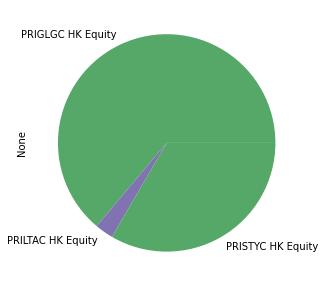

In [378]:
ef = EfficientFrontier(mu4, S4)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 12.9%
Annual volatility: 5.6%
Sharpe Ratio: 1.95


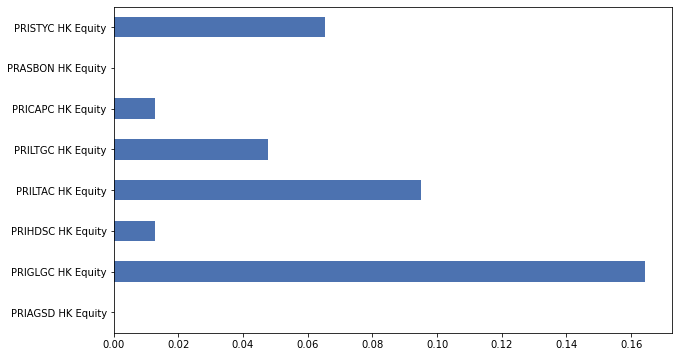

In [379]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu4.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
-20.450834949359315
Portfolio return compared to train set (+- %):
-33.38521008830744
Percentage change compared to train set (+- %):
-258.11227623805
Compare to benchmark (+- %):
-25.550834949359313


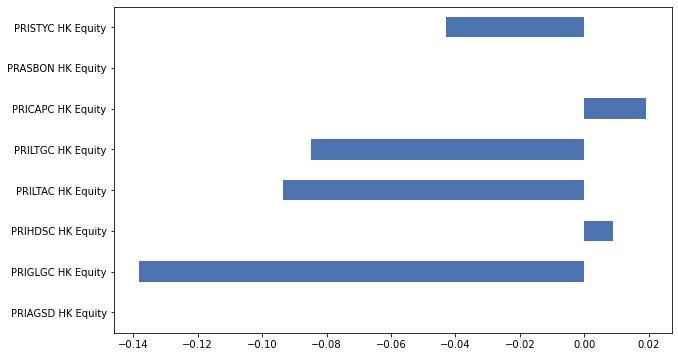

In [380]:
#calculate the asset returns in our portfolio.
ret_data = tfour.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff4 = (sum(port_ret) - ret)*100
print(diff4)
print("Percentage change compared to train set (+- %):")
perch4 = diff4/ret
print(perch4)
compare4=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare4)

tmu4.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 5th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.50291), ('PRIHDSC HK Equity', 0.06384), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.05338), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.37987)])
Performance of function 1a portfolio in train period:


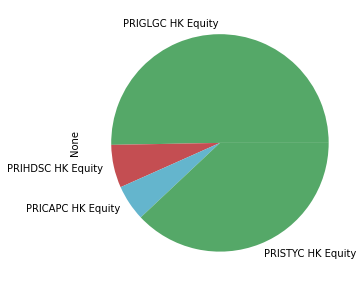

In [381]:
ef = EfficientFrontier(mu5, S5)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 10.5%
Annual volatility: 5.7%
Sharpe Ratio: 1.50


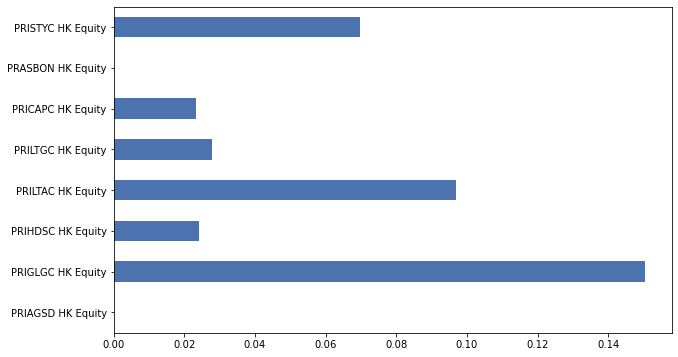

In [382]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu5.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
-0.9974010612932407
Portfolio return compared to train set (+- %):
-11.489512381903694
Percentage change compared to train set (+- %):
-109.5061997610907
Compare to benchmark (+- %):
-6.09740106129324


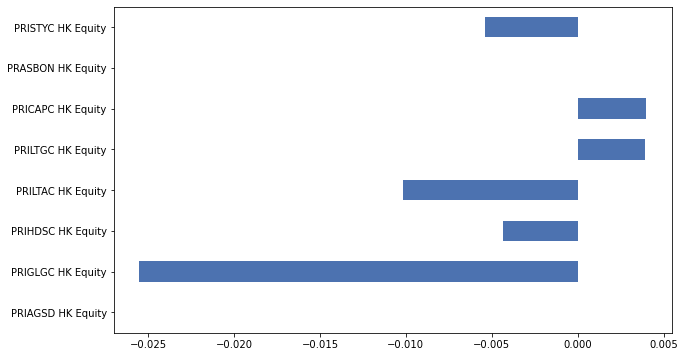

In [383]:
#calculate the asset returns in our portfolio.
ret_data = tfive.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff5 = (sum(port_ret) - ret)*100
print(diff5)
print("Percentage change compared to train set (+- %):")
perch5 = diff5/ret
print(perch5)
compare5=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare5)

tmu5.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 6th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 1.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.0)])
Performance of function 1a portfolio in train period:


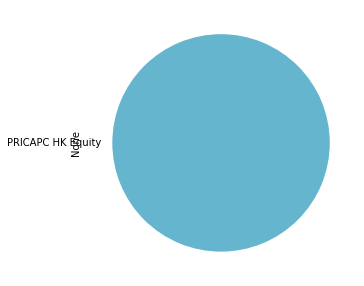

In [384]:
ef = EfficientFrontier(mu6, S6)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 2.3%
Annual volatility: 0.9%
Sharpe Ratio: 0.29


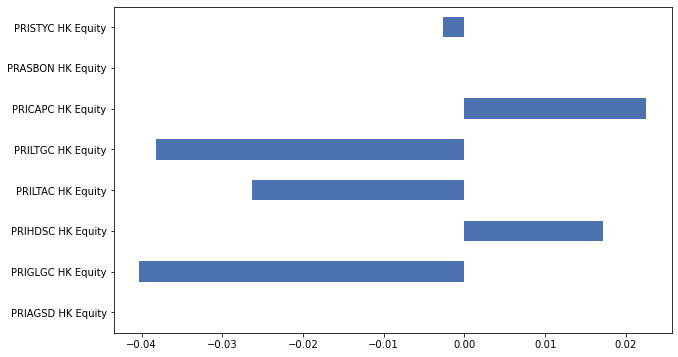

In [385]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu6.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
0.015183483154446176
Portfolio return compared to train set (+- %):
-2.2386414126687515
Percentage change compared to train set (+- %):
-99.32632374491097
Compare to benchmark (+- %):
-5.084816516845553


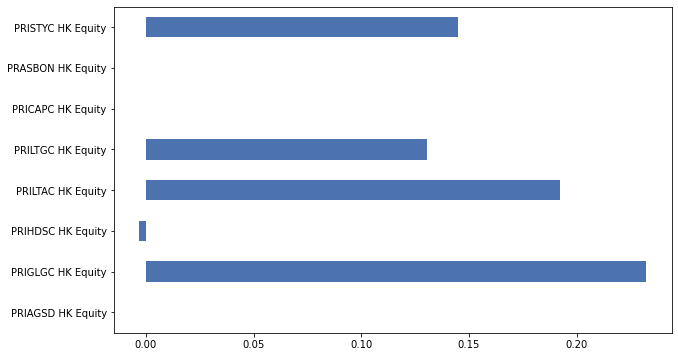

In [386]:
#calculate the asset returns in our portfolio.
ret_data = tsix.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff6 = (sum(port_ret) - ret)*100
print(diff6)
print("Percentage change compared to train set (+- %):")
perch6 = diff6/ret
print(perch6)
compare6=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare6)

tmu6.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 7th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 1.0)])
Performance of function 1a portfolio in train period:


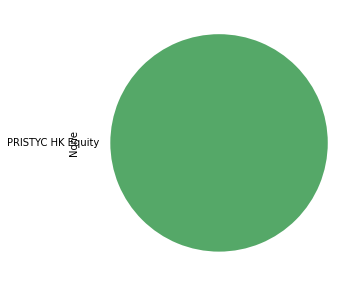

In [387]:
ef = EfficientFrontier(mu7, S7)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 2.9%
Annual volatility: 8.3%
Sharpe Ratio: 0.11


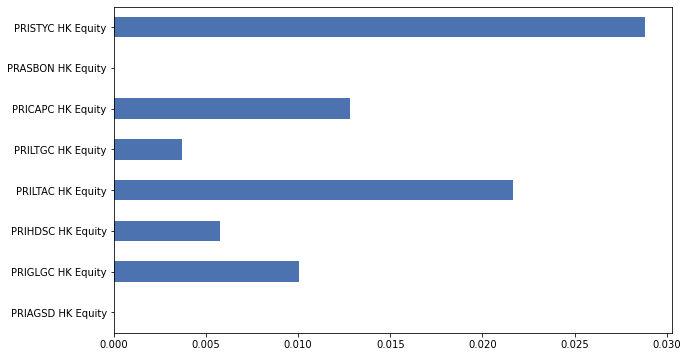

In [388]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu7.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
5.855560532866311
Portfolio return compared to train set (+- %):
2.9734219706980762
Percentage change compared to train set (+- %):
103.16721096369389
Compare to benchmark (+- %):
0.7555605328663111


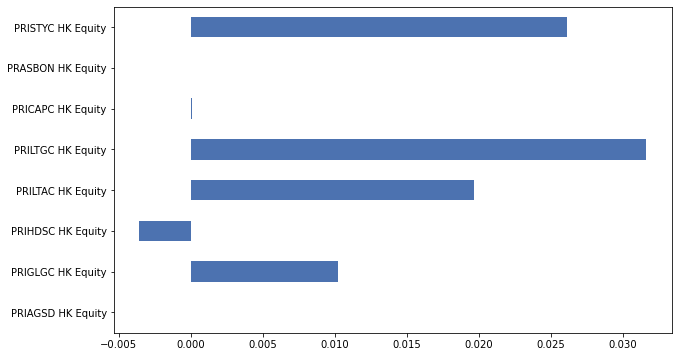

In [389]:
#calculate the asset returns in our portfolio.
ret_data = tseven.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff7 = (sum(port_ret) - ret)*100
print(diff7)
print("Percentage change compared to train set (+- %):")
perch7 = diff7/ret
print(perch7)
compare7=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare7)

tmu7.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 8th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.28566), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.71434)])
Performance of function 1a portfolio in train period:


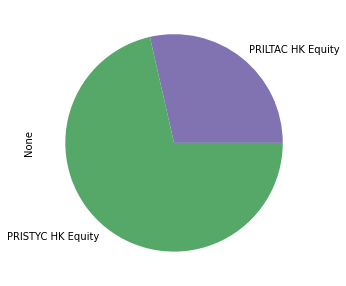

In [390]:
ef = EfficientFrontier(mu8, S8)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 3.0%
Annual volatility: 7.3%
Sharpe Ratio: 0.14


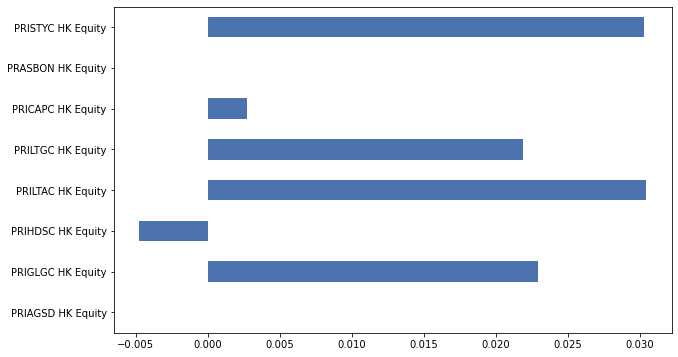

In [391]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu8.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
-0.15191065516592944
Portfolio return compared to train set (+- %):
-3.1842722893615742
Percentage change compared to train set (+- %):
-105.00964836953641
Compare to benchmark (+- %):
-5.251910655165929


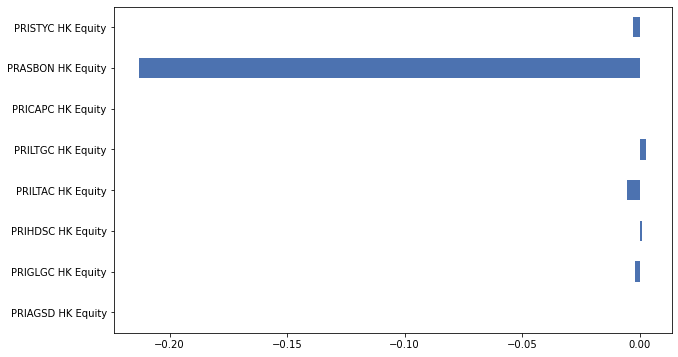

In [392]:
#calculate the asset returns in our portfolio.
ret_data = teight.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff8 = (sum(port_ret) - ret)*100
print(diff8)
print("Percentage change compared to train set (+- %):")
perch8 = diff8/ret
print(perch8)
compare8=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare8)

tmu8.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 9th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.86875), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.13125)])
Performance of function 1a portfolio in train period:


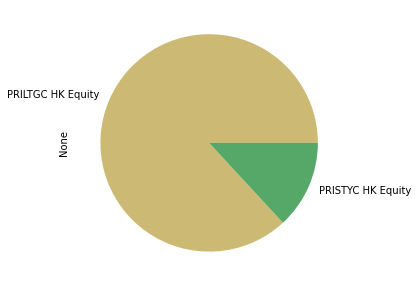

In [393]:
ef = EfficientFrontier(mu9, S9)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 8.5%
Annual volatility: 3.6%
Sharpe Ratio: 1.79


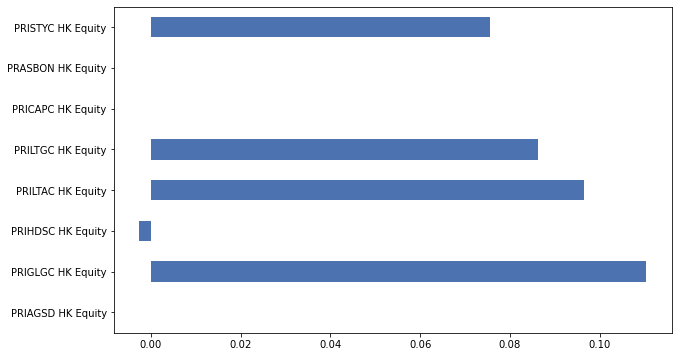

In [394]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu9.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
6.617562213145739
Portfolio return compared to train set (+- %):
-1.8690699879396395
Percentage change compared to train set (+- %):
-22.023694955233232
Compare to benchmark (+- %):
1.5175622131457391


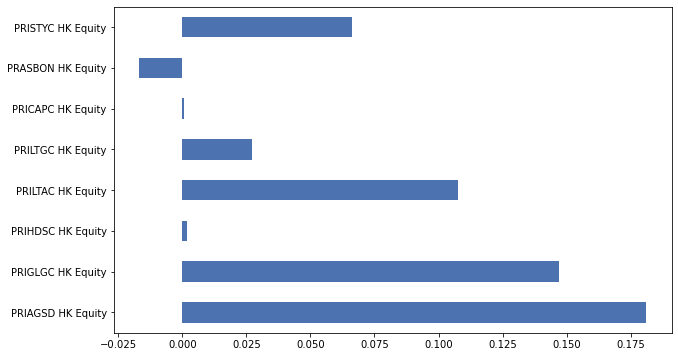

In [395]:
#calculate the asset returns in our portfolio.
ret_data = tnine.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff9 = (sum(port_ret) - ret)*100
print(diff9)
print("Percentage change compared to train set (+- %):")
perch9 = diff9/ret
print(perch9)
compare9=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare9)

tmu9.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 10th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.37949), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.62051)])
Performance of function 1a portfolio in train period:


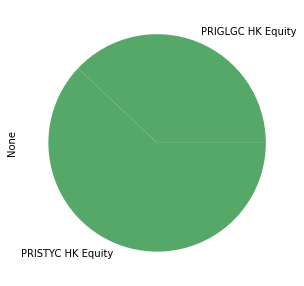

In [396]:
ef = EfficientFrontier(mu10, S10)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 3.6%
Annual volatility: 6.6%
Sharpe Ratio: 0.24


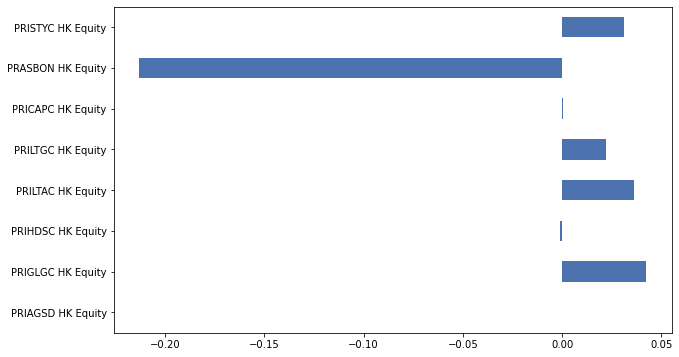

In [397]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu10.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
7.209128019411651
Portfolio return compared to train set (+- %):
3.6531577502763493
Percentage change compared to train set (+- %):
102.73307912567786
Compare to benchmark (+- %):
2.109128019411651


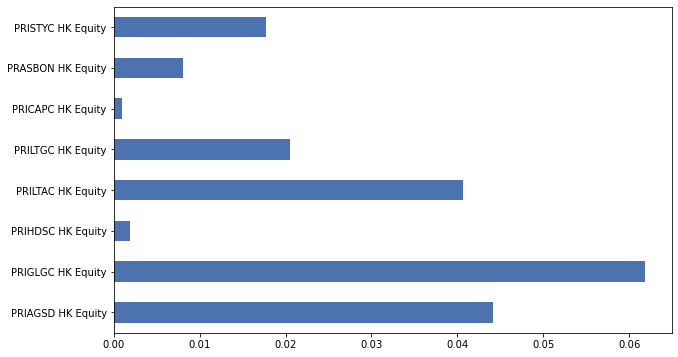

In [398]:
#calculate the asset returns in our portfolio.
ret_data = tten.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff10 = (sum(port_ret) - ret)*100
print(diff10)
print("Percentage change compared to train set (+- %):")
perch10 = diff10/ret
print(perch10)
compare10=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare10)

tmu10.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 11th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.99642), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.00358)])
Performance of function 1a portfolio in train period:


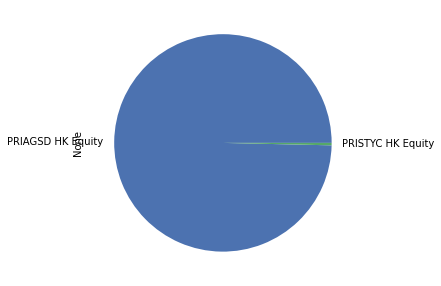

In [399]:
ef = EfficientFrontier(mu11, S11)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 18.1%
Annual volatility: 2.0%
Sharpe Ratio: 8.22


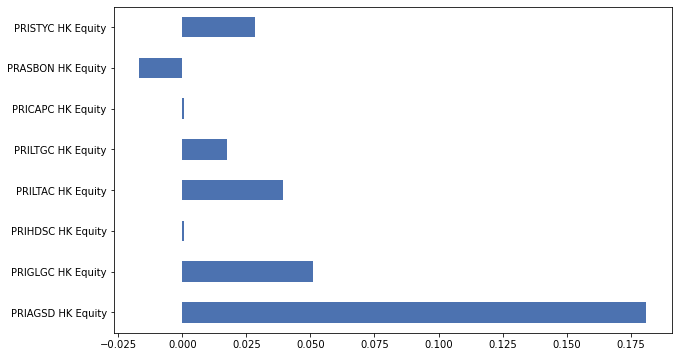

In [400]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu11.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
-1.6335290157786064
Portfolio return compared to train set (+- %):
-19.693690080506308
Percentage change compared to train set (+- %):
-109.04493049604613
Compare to benchmark (+- %):
-6.733529015778606


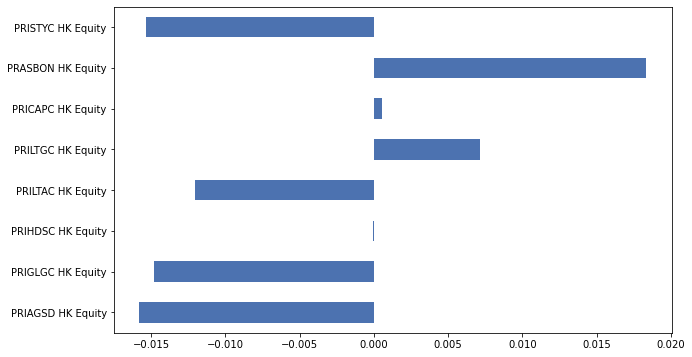

In [401]:
#calculate the asset returns in our portfolio.
ret_data = televen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff11 = (sum(port_ret) - ret)*100
print(diff11)
print("Percentage change compared to train set (+- %):")
perch11 = diff11/ret
print(perch11)
compare11=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare11)

tmu11.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 12th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.81216), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.18784)])
Performance of function 1a portfolio in train period:


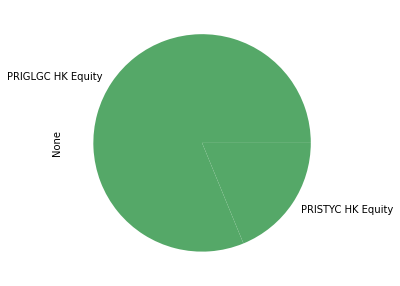

In [402]:
ef = EfficientFrontier(mu12, S12)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 8.0%
Annual volatility: 6.5%
Sharpe Ratio: 0.93


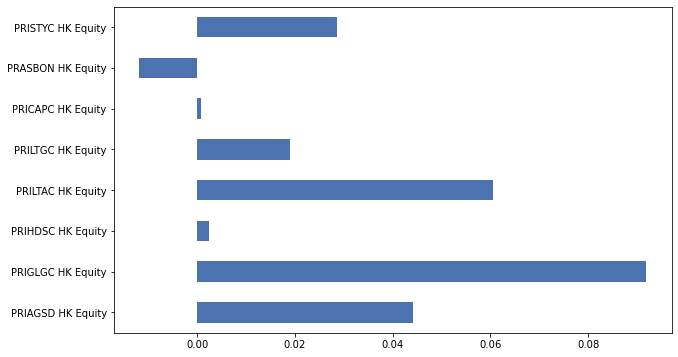

In [403]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu12.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
11.341096841951012
Portfolio return compared to train set (+- %):
3.3402933891871047
Percentage change compared to train set (+- %):
41.74947439851416
Compare to benchmark (+- %):
6.241096841951013


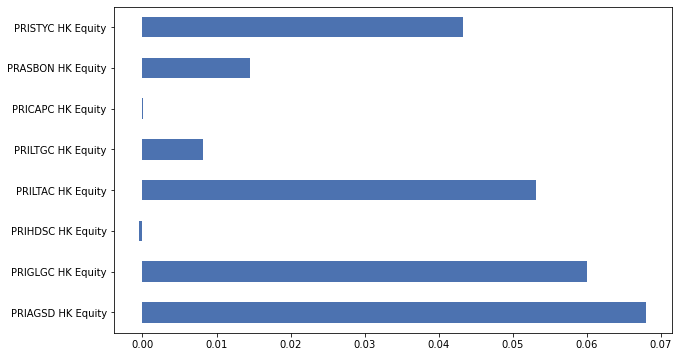

In [404]:
#calculate the asset returns in our portfolio.
ret_data = ttwelve.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff12 = (sum(port_ret) - ret)*100
print(diff12)
print("Percentage change compared to train set (+- %):")
perch12 = diff12/ret
print(perch12)
compare12=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare12)

tmu12.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 13th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 1.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.0)])
Performance of function 1a portfolio in train period:


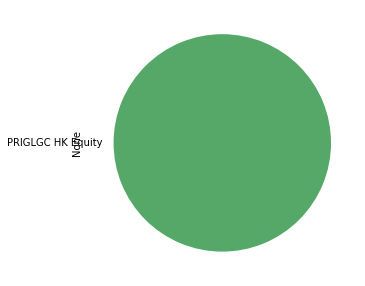

In [405]:
ef = EfficientFrontier(mu13, S13)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 3.4%
Annual volatility: 8.7%
Sharpe Ratio: 0.16


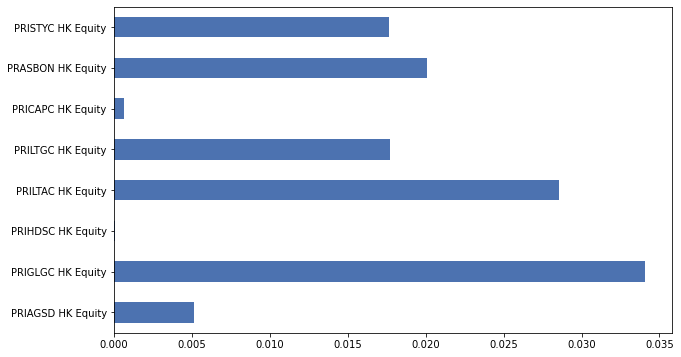

In [406]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu13.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
20.09237087238037
Portfolio return compared to train set (+- %):
16.684412312217255
Percentage change compared to train set (+- %):
489.5720419622322
Compare to benchmark (+- %):
14.992370872380372


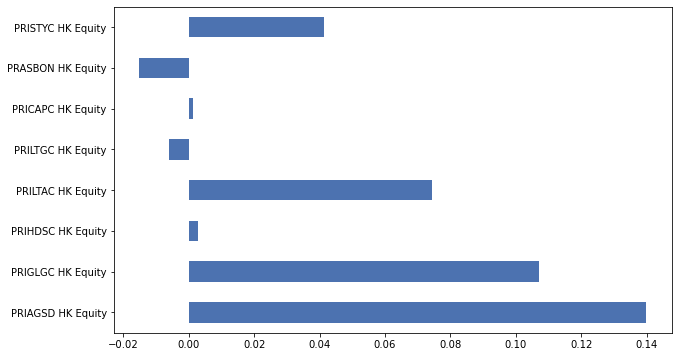

In [407]:
#calculate the asset returns in our portfolio.
ret_data = tthirteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff13 = (sum(port_ret) - ret)*100
print(diff13)
print("Percentage change compared to train set (+- %):")
perch13 = diff13 /ret
print(perch13)
compare13=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare13)

tmu13.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 14th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 1.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.0)])
Performance of function 1a portfolio in train period:


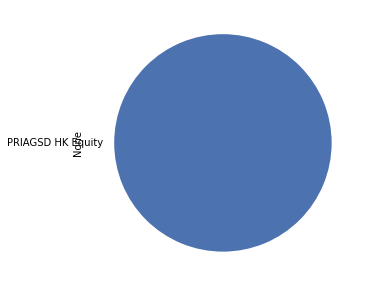

In [408]:
ef = EfficientFrontier(mu14, S14)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 4.8%
Annual volatility: 10.9%
Sharpe Ratio: 0.25


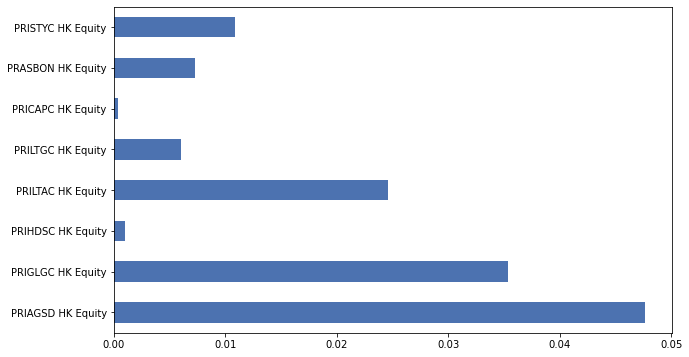

In [409]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu14.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
3.4084129637321214
Portfolio return compared to train set (+- %):
-1.356197524871472
Percentage change compared to train set (+- %):
-28.463974717667735
Compare to benchmark (+- %):
-1.6915870362678782


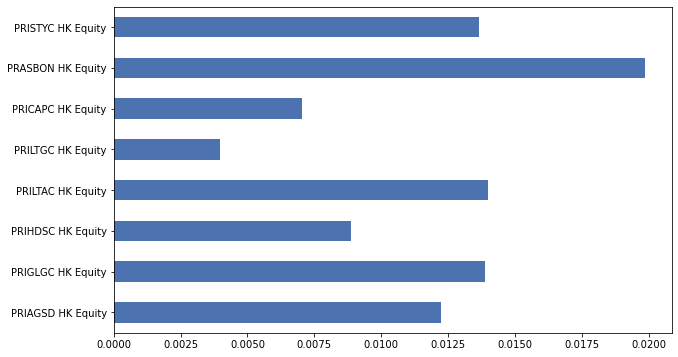

In [410]:
#calculate the asset returns in our portfolio.
ret_data = tfourteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff14 = (sum(port_ret) - ret)*100
print(diff14)
print("Percentage change compared to train set (+- %):")
perch14 = diff14 /ret
print(perch14)
compare14=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare14)

tmu14.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 15th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.37686), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.62314)])
Performance of function 1a portfolio in train period:


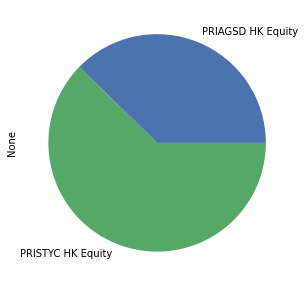

In [411]:
ef = EfficientFrontier(mu15, S15)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 4.9%
Annual volatility: 5.3%
Sharpe Ratio: 0.56


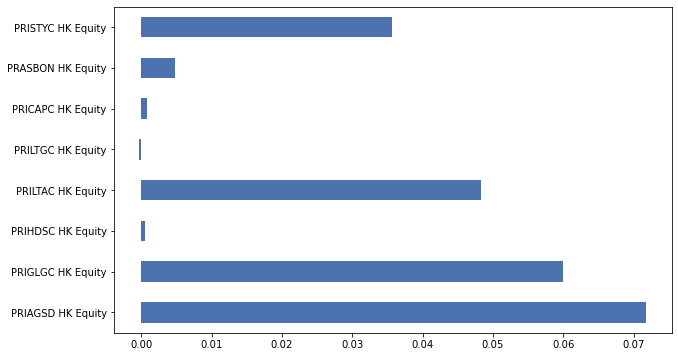

In [412]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu15.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
5.738960990947949
Portfolio return compared to train set (+- %):
0.8093197432469341
Percentage change compared to train set (+- %):
16.417416655306674
Compare to benchmark (+- %):
0.6389609909479494


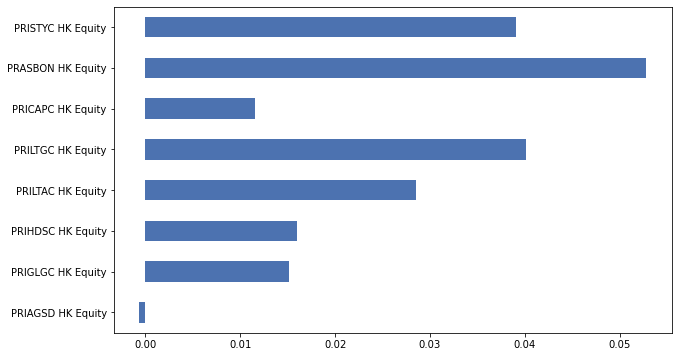

In [413]:
#calculate the asset returns in our portfolio.
ret_data = tfifteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff15 = (sum(port_ret) - ret)*100
print(diff15)
print("Percentage change compared to train set (+- %):")
perch15 = diff15/ret
print(perch15)
compare15=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare15)

tmu15.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

## Summary of Backtesting of Function 1a

In [415]:
perch_all = [perch1,perch2,perch3,perch4,perch5,perch6,perch7,perch8,perch9,perch10,perch11,perch12,perch13,perch14,perch15]
compare_all = [compare1,compare2,compare3,compare4,compare5,compare6,compare7,compare8,compare9,compare10,compare11,compare12,compare13,compare14,compare15]
mean_perch = sum(perch_all) / len(perch_all)
mean_compare = sum(compare_all) / len(compare_all)
print( "Function 1a Average error (%): " + str(mean_perch))
print( "Function 1a Average return compare to Benchmark(%): " + str(mean_compare))
#print( "Function 1a Accuracy (%): " + str(100-mean_perch))

Function 1a Average error (%): 49.363031757474
Function 1a Average return compare to Benchmark(%): 1.252333456001074


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Function 2a - Portfolio Optimization with given Risk Tolerance
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

Text(0.5, 1.0, 'Fund Portfolio')

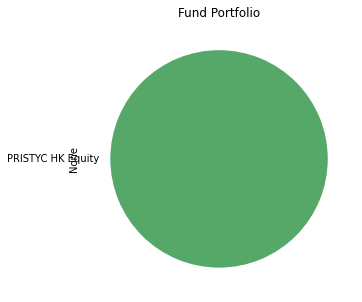

In [117]:
ef = EfficientFrontier(mu1, S1)

ef.efficient_risk(target_volatility=0.1) #input desired volatility - default as ten percent
weights = ef.clean_weights()
weights

pd.Series(weights).plot.pie(figsize=(5,5))
plt.title("Fund Portfolio")

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 1st five-year Backtesting  (for Function 2a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.39732), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.60268)])
Performance of function 1a portfolio in train period:


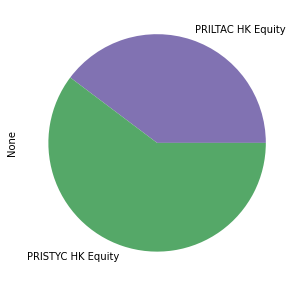

In [118]:
ef = EfficientFrontier(mu15, S15)

weight2a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Function 3 - Minimise risk for a given return

In [119]:
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.efficient_return(target_return=0.04, market_neutral=True)
weights = ef.clean_weights()
weights

OrderedDict([('PRIAGSD HK Equity', 0.4237),
             ('PRIGLGC HK Equity', 0.03087),
             ('PRIHDSC HK Equity', -0.68904),
             ('PRILTAC HK Equity', 0.24745),
             ('PRILTGC HK Equity', -0.20785),
             ('PRICAPC HK Equity', -0.63026),
             ('PRASBON HK Equity', 0.23079),
             ('PRISTYC HK Equity', 0.59434)])

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Plotting Efficient Frontier

In [120]:
from pypfopt import CLA, plotting

cla = CLA(mu1, S1)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 2.6%
Annual volatility: 3.9%
Sharpe Ratio: 0.16


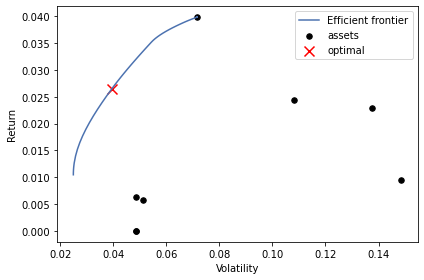

In [121]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

# This scheme in a nutshell:

##         Any portfolio with volatility higher than 11.1% is bad because you earn the same afterwards. The highest return you can get is 5.0%.

In [75]:
risktolerance, annualreturn = [], []
for rt2 in np.arange(0.02, 1, 0.001):
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(target_volatility=rt2)
    weights = ef.clean_weights()
    ret, volatility, Sharpe = ef.portfolio_performance(verbose=True)
    annualreturn.append(ret)
    risktolerance.append(rt2)


Expected annual return: 2.0%
Annual volatility: 2.0%
Sharpe Ratio: -0.02
Expected annual return: 2.0%
Annual volatility: 2.1%
Sharpe Ratio: 0.02
Expected annual return: 2.1%
Annual volatility: 2.2%
Sharpe Ratio: 0.05
Expected annual return: 2.2%
Annual volatility: 2.3%
Sharpe Ratio: 0.08
Expected annual return: 2.3%
Annual volatility: 2.4%
Sharpe Ratio: 0.11
Expected annual return: 2.3%
Annual volatility: 2.5%
Sharpe Ratio: 0.13
Expected annual return: 2.4%
Annual volatility: 2.6%
Sharpe Ratio: 0.15
Expected annual return: 2.5%
Annual volatility: 2.7%
Sharpe Ratio: 0.18
Expected annual return: 2.5%
Annual volatility: 2.8%
Sharpe Ratio: 0.19
Expected annual return: 2.6%
Annual volatility: 2.9%
Sharpe Ratio: 0.21
Expected annual return: 2.7%
Annual volatility: 3.0%
Sharpe Ratio: 0.23
Expected annual return: 2.8%
Annual volatility: 3.1%
Sharpe Ratio: 0.24
Expected annual return: 2.8%
Annual volatility: 3.2%
Sharpe Ratio: 0.26
Expected annual return: 2.9%
Annual volatility: 3.3%
Sharpe Rat

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

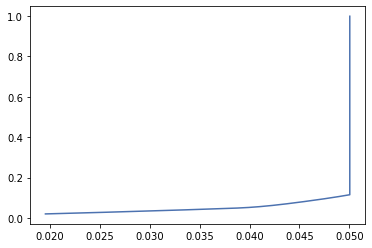

In [76]:
plt.plot(annualreturn, risktolerance)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)